<a href="https://colab.research.google.com/github/TivsLThree/CAP-4630-Artificial-Intelligence/blob/master/CNN/FlagCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils as nu
import cv2

flag_names = ["australia","canada","china","cuba","japan","malaysia","monaco","peru","poland","singapore","usa","vietnam"];
flag_dict = {k:v for (v,k) in enumerate(flag_names)}
flag_dict_inv = {k:v for (k,v) in enumerate(flag_names)}
def retrieve_data():
  images = []
  labels = []
  for f in flag_names:
    i = 1;
    while i > 0:
      try:
          im = io.imread("https://github.com/TivsLThree/FlagCNN/blob/master/Images/" + f +"_" + str(i) + ".png?raw=true");
          im = im[:,:,:3] # get rid of transparency. 
     #   res = cv2.resize(im, dsize=(23 * 40, 13 * 40), interpolation=cv2.INTER_CUBIC)
        #im = im.reshape((1,) + im.shape)
          labels.append(flag_dict[f])
          images.append(im)
      except:
          i = -999;
      i += 1
  labels = nu.to_categorical(labels)
  return (images, labels)
images, labels = retrieve_data();



<Figure size 432x288 with 0 Axes>

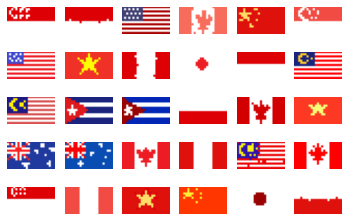

In [44]:
num = 6;
plt.figure()
f, ax = plt.subplots(num-1, num)
im = images.copy();
np.random.shuffle(im)

for i in range(num-1):
  for j in range(num):
    ax[i][j].axis('off')
    ax[i][j].imshow(im[i*num + j])
    #plt.show()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import cv2
from PIL import Image
import tensorflow as tf


def recolor(image, r =0.03):
  return tf.image.adjust_hue(image=image, delta=r)
d = ImageDataGenerator(preprocessing_function=recolor, rescale= 1./255,rotation_range=6, width_shift_range= 2, height_shift_range= 2, zoom_range= 0.3, brightness_range=[0.5, 1.5], channel_shift_range=0.25)
#it = td.flow(X, Y)
train_gen = d.flow(x=np.array(images), y=np.array(labels), batch_size=36);

validation_datagen = ImageDataGenerator(rescale = 1./255);
# DO NOT DO THIS. I realized I used my train data set as my validation data set at the same time. This is bad. Do not cross contaminate. 
#thooough, the train dataset is all augmented
valid_gen = validation_datagen.flow(x = np.array(images), y = np.array(labels))

### Augmented Images

<Figure size 432x288 with 0 Axes>

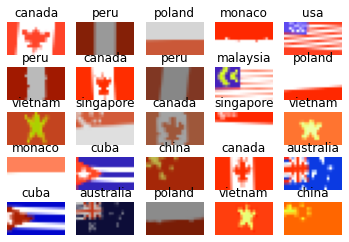

In [55]:
augX, augY = train_gen.next();

num = int(np.sqrt(len(augY)));
plt.figure()
f, ax = plt.subplots(num, num)
np.random.shuffle(im)

for i in range(num):
  for j in range(num):
    ax[i][j].axis('off')
    s = str(flag_dict_inv[np.argmax(augY[i*num + j])])
    ax[i][j].set_title(s)
    ax[i][j].imshow(augX[i*num + j])
    #plt.show()

In [0]:
import keras.layers as layers
import keras
cnn = keras.Sequential();

cnn.add(layers.Conv2D(filters = 32, kernel_size=(3,3),strides = (2,2), input_shape=images[0].shape, padding = 'same'))
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2), strides = 2))

cnn.add(layers.Conv2D(filters = 64, kernel_size=(2,2), strides = (1,1,), padding = 'valid'));
cnn.add(layers.Activation('relu'))
#cnn.add(layers.MaxPool2D(pool_size=(2,2), strides = 2))

cnn.add(layers.Flatten());
cnn.add(layers.Dense(64));
cnn.add(layers.Activation('relu'));
        
cnn.add(layers.Dropout(0.2));
        
cnn.add(layers.Dense(len(flag_names), activation='softmax'));

cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])


Epoch 1/12
10/10 [==============================] - 3s 283ms/step - loss: 2.3598 - accuracy: 0.1765 - val_loss: 2.2237 - val_accuracy: 0.4118
Epoch 2/12
10/10 [==============================] - 3s 252ms/step - loss: 2.0206 - accuracy: 0.3912 - val_loss: 1.4513 - val_accuracy: 0.7647
Epoch 3/12
10/10 [==============================] - 3s 252ms/step - loss: 1.4516 - accuracy: 0.6471 - val_loss: 0.5364 - val_accuracy: 0.8824
Epoch 4/12
10/10 [==============================] - 3s 252ms/step - loss: 0.9176 - accuracy: 0.7059 - val_loss: 0.1756 - val_accuracy: 0.9412
Epoch 5/12
10/10 [==============================] - 3s 252ms/step - loss: 0.6662 - accuracy: 0.7382 - val_loss: 0.1236 - val_accuracy: 0.9412
Epoch 6/12
10/10 [==============================] - 3s 252ms/step - loss: 0.4569 - accuracy: 0.8529 - val_loss: 0.3494 - val_accuracy: 0.9706
Epoch 7/12
10/10 [==============================] - 3s 252ms/step - loss: 0.4003 - accuracy: 0.8588 - val_loss: 0.0240 - val_accuracy: 0.8824
Epoch 

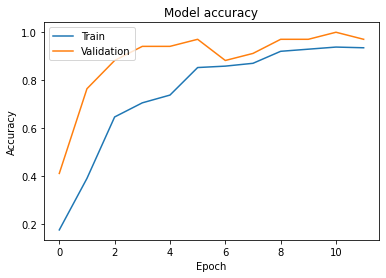

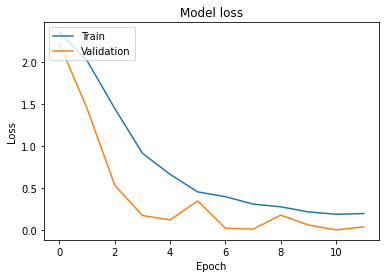

In [57]:
history = cnn.fit_generator(train_gen, steps_per_epoch=10, epochs=12, validation_data=valid_gen, validation_steps=len(images));

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#cnn.save("flag_cnn.h5")

Looks good enough to try out!

In [0]:
!pip install tensorflowjs
from google.colab import files
cnn.save("keras.h5")
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/
!zip -r model.zip model 

files.download('model.zip')